# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import os
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)

---

# Carga de datos

In [2]:
train_auctions = pd.read_csv("../../features/entrenar_auctions_final.csv")

In [3]:
train_auctions.set_index("device_id", inplace=True)

In [4]:
#train_auctions = train_auctions.reindex(sorted(train_auctions.columns), axis=1)

In [5]:
# Filtro
#train_auctions = train_auctions.loc[(train_auctions.T.agg("sum") != 0)]

---

In [6]:
X_auctions, y_auctions = train_auctions.drop("target", axis=1), train_auctions["target"]
X_train_auctions, X_test_auctions, y_train_auctions, y_test_auctions = \
    train_test_split(X_auctions, y_auctions, test_size=0.33, random_state=0)

filtro_auctions = (X_auctions.T.agg("sum") != 0)
X_auctions = X_auctions.loc[filtro_auctions]
y_auctions = y_auctions.loc[filtro_auctions]

dtrain_auctions = xgb.DMatrix(data=X_train_auctions, label=y_train_auctions)
dtest_auctions = xgb.DMatrix(data=X_test_auctions, label=y_test_auctions)

---

In [7]:
train_installs = pd.read_csv("../../features/entrenar_installs_final.csv")
train_installs.set_index("device_id", inplace=True)
#train_installs = train_installs.reindex(sorted(train_installs.columns), axis=1)

In [8]:
# Filtro
#train_installs = train_installs.loc[train_installs.T.agg("sum") != 0]

---

In [9]:
X_installs, y_installs = train_installs.drop("target", axis=1), train_installs["target"]
X_train_installs, X_test_installs, y_train_installs, y_test_installs = \
    train_test_split(X_installs, y_installs, test_size=0.33, random_state=0)

filtro_installs = (X_installs.T.agg("sum") != 0)
X_installs = X_installs.loc[filtro_installs]
y_installs = y_installs.loc[filtro_installs]

dtrain_installs = xgb.DMatrix(data=X_train_installs, label=y_train_installs)
dtest_installs = xgb.DMatrix(data=X_test_installs, label=y_test_installs)

In [10]:
beep(3)

0

---

# Entrenamiento - Auctions

In [11]:
space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 500+1)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 9, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 0.5, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 5,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}


def objective(space):
    model = xgb.train(space, dtrain_auctions,evals=[(dtest_auctions, "test")], verbose_eval=False, )
    pred = model.predict(dtest_auctions)
    rmse = np.sqrt(mean_squared_error(y_test_auctions, pred))
    return{'loss':rmse, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print(best)
#100%|██████████| 25/25 [05:35<00:00, 17.91s/it, best loss: 62332.30151971417]
#{'colsample_bytree': 0.9, 'eta': 0.4, 'gamma': 0.7000000000000001, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 350}

100%|██████████| 25/25 [05:35<00:00, 17.91s/it, best loss: 62332.30151971417]
{'colsample_bytree': 0.9, 'eta': 0.4, 'gamma': 0.7000000000000001, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 350}


---

# Entrenamiento - installs

In [25]:
space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 500+1)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 9, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 0.5, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 5,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}


def objective(space):
    model = xgb.train(space, dtrain_installs, evals=[(dtest_installs, "test")], verbose_eval=False, )
    pred = model.predict(dtest_installs)
    rmse = np.sqrt(mean_squared_error(y_test_installs, pred))
    return{'loss':rmse, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=75,
            trials=trials)

print(best)
#100%|██████████| 75/75 [01:41<00:00,  1.68s/it, best loss: 75304.25315421142]
#{'colsample_bytree': 0.8500000000000001, 'eta': 0.42500000000000004, 'gamma': 0.65, 'max_depth': 2, 'min_child_weight': 5.0, 'n_estimators': 182}

100%|██████████| 75/75 [01:41<00:00,  1.68s/it, best loss: 75304.25315421142]
{'colsample_bytree': 0.8500000000000001, 'eta': 0.42500000000000004, 'gamma': 0.65, 'max_depth': 2, 'min_child_weight': 5.0, 'n_estimators': 182}


In [29]:
beep(5)

0

---

# Prediccion

### Cargo features de los dispositivos de la competencia

In [26]:
predecir_auctions = pd.read_csv("../../features/predecir_auctions_final.csv", index_col=0)
#predecir_auctions = predecir_auctions.reindex(sorted(predecir_auctions.columns), axis=1)

In [27]:
for x in range(1,11):
    predecir_auctions["instalo_aplicacion_top_{}".format(x)] = predecir_auctions["instalo_aplicacion_top_{}".format(x)].fillna(False)

In [28]:
dpredecir_auctions = xgb.DMatrix(data=predecir_auctions)

In [29]:
predecir_installs = pd.read_csv("../../features/predecir_installs_final.csv", index_col=0)
#predecir_installs = predecir_installs.reindex(sorted(predecir_installs.columns), axis=1)

In [30]:
for x in range(1,11):
    predecir_installs["instalo_aplicacion_top_{}".format(x)] = predecir_auctions["instalo_aplicacion_top_{}".format(x)].fillna(False)

In [31]:
dpredecir_installs = xgb.DMatrix(data=predecir_installs)

---

In [32]:
dfinal_auctions = xgb.DMatrix(data=X_auctions, label=y_auctions)

In [33]:
#{'colsample_bytree': 0.9, 'eta': 0.4, 'gamma': 0.7000000000000001, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 350}
best_auctions = {
        'n_estimators': 350,
        'eta': 0.4,
        'max_depth': 5,
        'min_child_weight': 6.0,
        'gamma': 0.7,
        'colsample_bytree': 0.9,
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}
model_auctions = xgb.train(best_auctions, dfinal_auctions, verbose_eval=False)

In [34]:
predecir_auctions["label"] = model_auctions.predict(dpredecir_auctions)

---

In [35]:
dfinal_installs = xgb.DMatrix(data=X_installs, label=y_installs)

In [36]:
# {'colsample_bytree': 0.8500000000000001, 'eta': 0.42500000000000004, 'gamma': 0.65, 'max_depth': 2, 'min_child_weight': 5.0, 'n_estimators': 182}
best_installs = {
        'n_estimators': 182,
        'eta': 0.425,
        'max_depth': 2,
        'min_child_weight': 5.0,
        'gamma': 0.65,
        'colsample_bytree': 0.85,
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}
model_installs = xgb.train(best_installs, dfinal_installs, verbose_eval=False)

In [37]:
predecir_installs["label"] = model_installs.predict(dpredecir_installs)

---

In [38]:
def corregir(x):
    if x > 259200:
        return 259200
    elif x < 0:
        return 0
    else:
        return x

In [39]:
predecir_auctions["label"] = predecir_auctions["label"].apply(lambda x: corregir(x))

In [40]:
predecir_installs["label"] = predecir_installs["label"].apply(lambda x: corregir(x))

---

### Cargo archivo de submissions

In [41]:
submissions = pd.read_csv("../../../../data/tp2/target.csv")

In [42]:
predecir_auctions.reset_index(inplace=True)

In [43]:
predecir_auctions["ref_hash"] = predecir_auctions["ref_hash"].apply(lambda x: str(x)+"_st")

In [44]:
predecir_installs.reset_index(inplace=True)

In [45]:
predecir_installs["ref_hash"] = predecir_installs["ref_hash"].apply(lambda x: str(x)+"_sc")

In [46]:
rename_dict_auctions = predecir_auctions.set_index('ref_hash').to_dict()['label']

In [47]:
rename_dict_installs = predecir_installs.set_index('ref_hash').to_dict()['label']

In [48]:
tmp = submissions.copy()

In [49]:
tmp["obj"] = tmp["ref_hash"]

In [50]:
tmp["obj"] = tmp["obj"].replace(rename_dict_auctions)

In [51]:
tmp["obj"] = tmp["obj"].replace(rename_dict_installs)

In [52]:
tmp.set_index("ref_hash").to_csv("hasta_v6_outer_filtro_sin_nan.csv")

---

# Persistencia de modelos

In [53]:
model_installs.save_model("hasta_v6_outer_filtro_sin_nan.model")

In [54]:
model_installs.dump_model("hasta_v6_outer_filtro_sin_nan.dump", with_stats=True)

---

In [55]:
model_auctions.save_model("hasta_v6_outer_filtro_sin_nan.model")

In [56]:
model_auctions.dump_model("hasta_v6_outer_filtro_sin_nan.dump", with_stats=True)

---

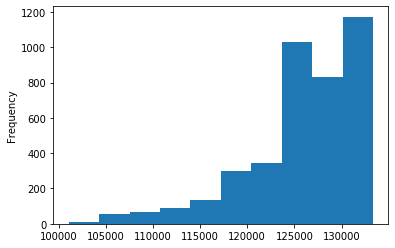

In [56]:
# esto es hasta v4, con outer, filtrando los 259200 en ambos. 70900
predecir_installs["label"].plot(kind="hist")

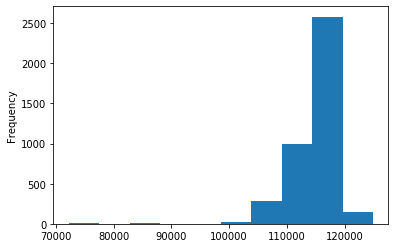

In [57]:
# Esto es sacando nans, hasta v6, con outer, filtrando los 259200 en ambos, filtrando nans. mejor puntuacion
predecir_installs["label"].plot(kind="hist")